In [35]:
import pandas as pd
import numpy as np
import opstrat as op
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandas_datareader.data as web  
import random
import sklearn
import math
import warnings 
from scipy.stats import norm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(palette = 'viridis')

#### Скачиваем очищенные данные с Мосбиржи (09.04.2023)

In [36]:
#данные предоставлены из доски на 9 апреля 2023 года

F0_sber = 216.1500
F0_lkoh = 4600
r = 0.0715     #дюрация 0.1 => процентная ставка 7,15% годовых (ставка ЦБ на 9 апреля 2023 года)
T = 38 / 365   #дней до экспирации опциона 

df_sber = pd.read_csv('Data/SBER_clear_170523_090423.csv')
df_lkoh = pd.read_csv('Data/LKOH_clear_170523_090423.csv')

In [37]:
def bs_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    V = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return V

def vega(S0, K, T, r, sigma):
    d1 = ((np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
    vega = S0 * norm.cdf(d1, 0.0, 1.0) * np.sqrt(T)
    return vega

def implied_vol(S0, K, T, r, C0):
    sigma_est = 1
    it = 100
    for i in range(it):
        sigma_est -= (bs_call(S0, K, T, r, sigma_est) - C0) / vega(S0, K, T, r, sigma_est)
    return sigma_est

In [38]:
df_sber['IV calc'] = implied_vol(
            C0 = df_sber['Price'],
            S0 = F0_sber, 
            K = df_sber['Strike'],
            T = T,
            r = r)

df_lkoh['IV calc'] = implied_vol(
            C0 = df_lkoh['Price'],
            S0 = F0_lkoh, 
            K = df_lkoh['Strike'],
            T = T,
            r = r)

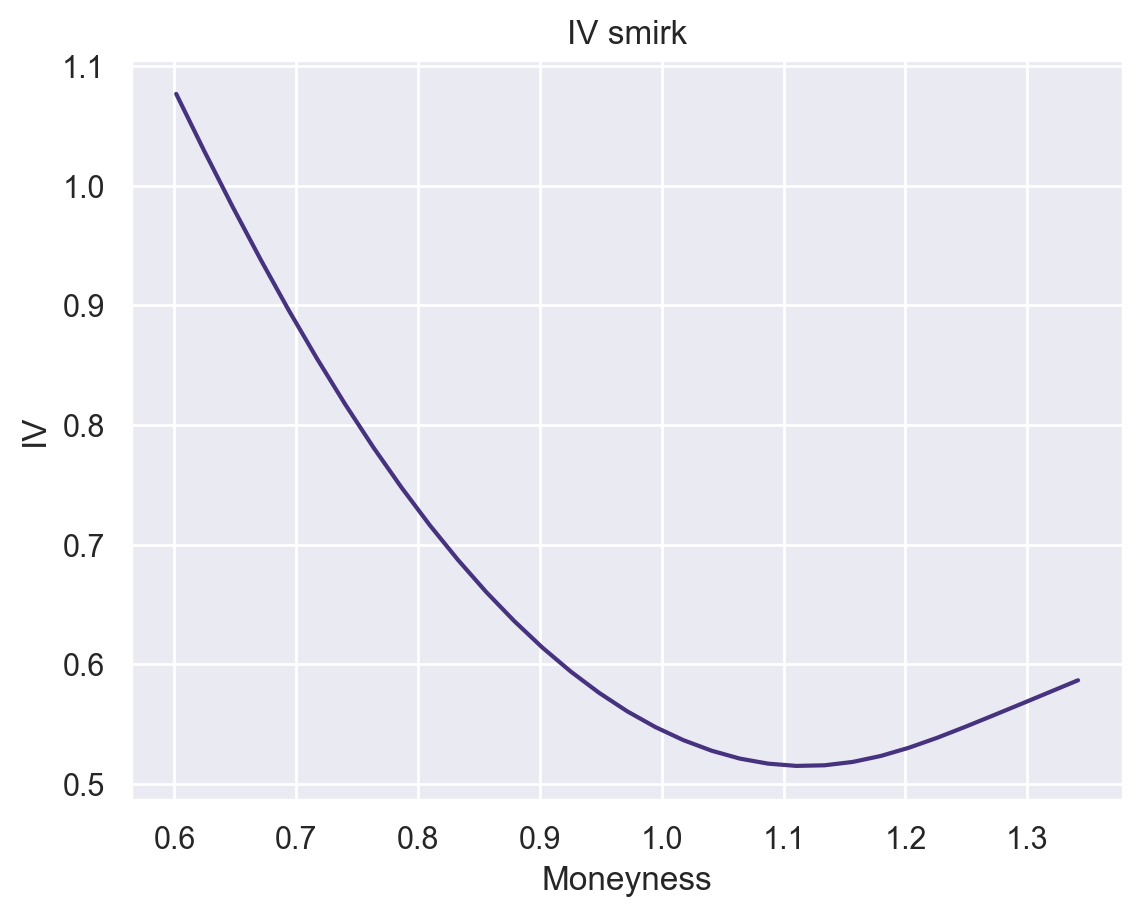

In [39]:
plt.title('IV smirk')

plt.plot(df_sber['Strike'] / F0_sber, df_sber['IV'])

plt.ylabel('IV')
plt.xlabel('Moneyness')

plt.show()

In [40]:
num_of_options_sber = df_sber.shape[0]
num_of_options_lkoh = df_lkoh.shape[0]

#### Симуляция динамика цены акции методом Монте-Карло

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

np.random.seed(1234)
# Параметры опциона и рынка
r = r           # ключевая ставка ЦБ
sigma = 0.59    # стандартное отклонение 
npaths = 20000  # количество реализаций
nsteps = 250    # количество шагов
npathsplot = 40 # количество выводимых на картинке реализаций 
T = T           # время до экспирации опциона
F0 = F0_sber    # текущая стоимость базового актива


def plotMonteCarlo(F0, r, sigma, T, npaths = 20000, nsteps = 250, npathsplot = 40, save=False, file='fig.png'):
    dt = T/nsteps
    t = np.linspace(0, T, nsteps+1) # time grid

    # Compute the increments of the arithmetic brownian motion X = log(S/S0)
    dX = (r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(size=(npaths, nsteps))

    # Accumulate the increments starting at 0
    X = np.concatenate((np.zeros((npaths, 1)), np.cumsum(dX, axis=1)), axis=1)

    # Transform to geometric Brownian motion
    S = F0*np.exp(X)

    # Plot potential stock price paths
    fig = plt.figure(figsize=(10, 7)) 
    ax = fig.add_subplot(111)
    for i in range(0, npaths, round(npaths/npathsplot)):
        ax.plot(t, S[i,:])
    ax.plot(t, np.mean(S, axis=0), 'k--') # mean path
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$X_t$')
    if save:
        plt.savefig(file)
    return S

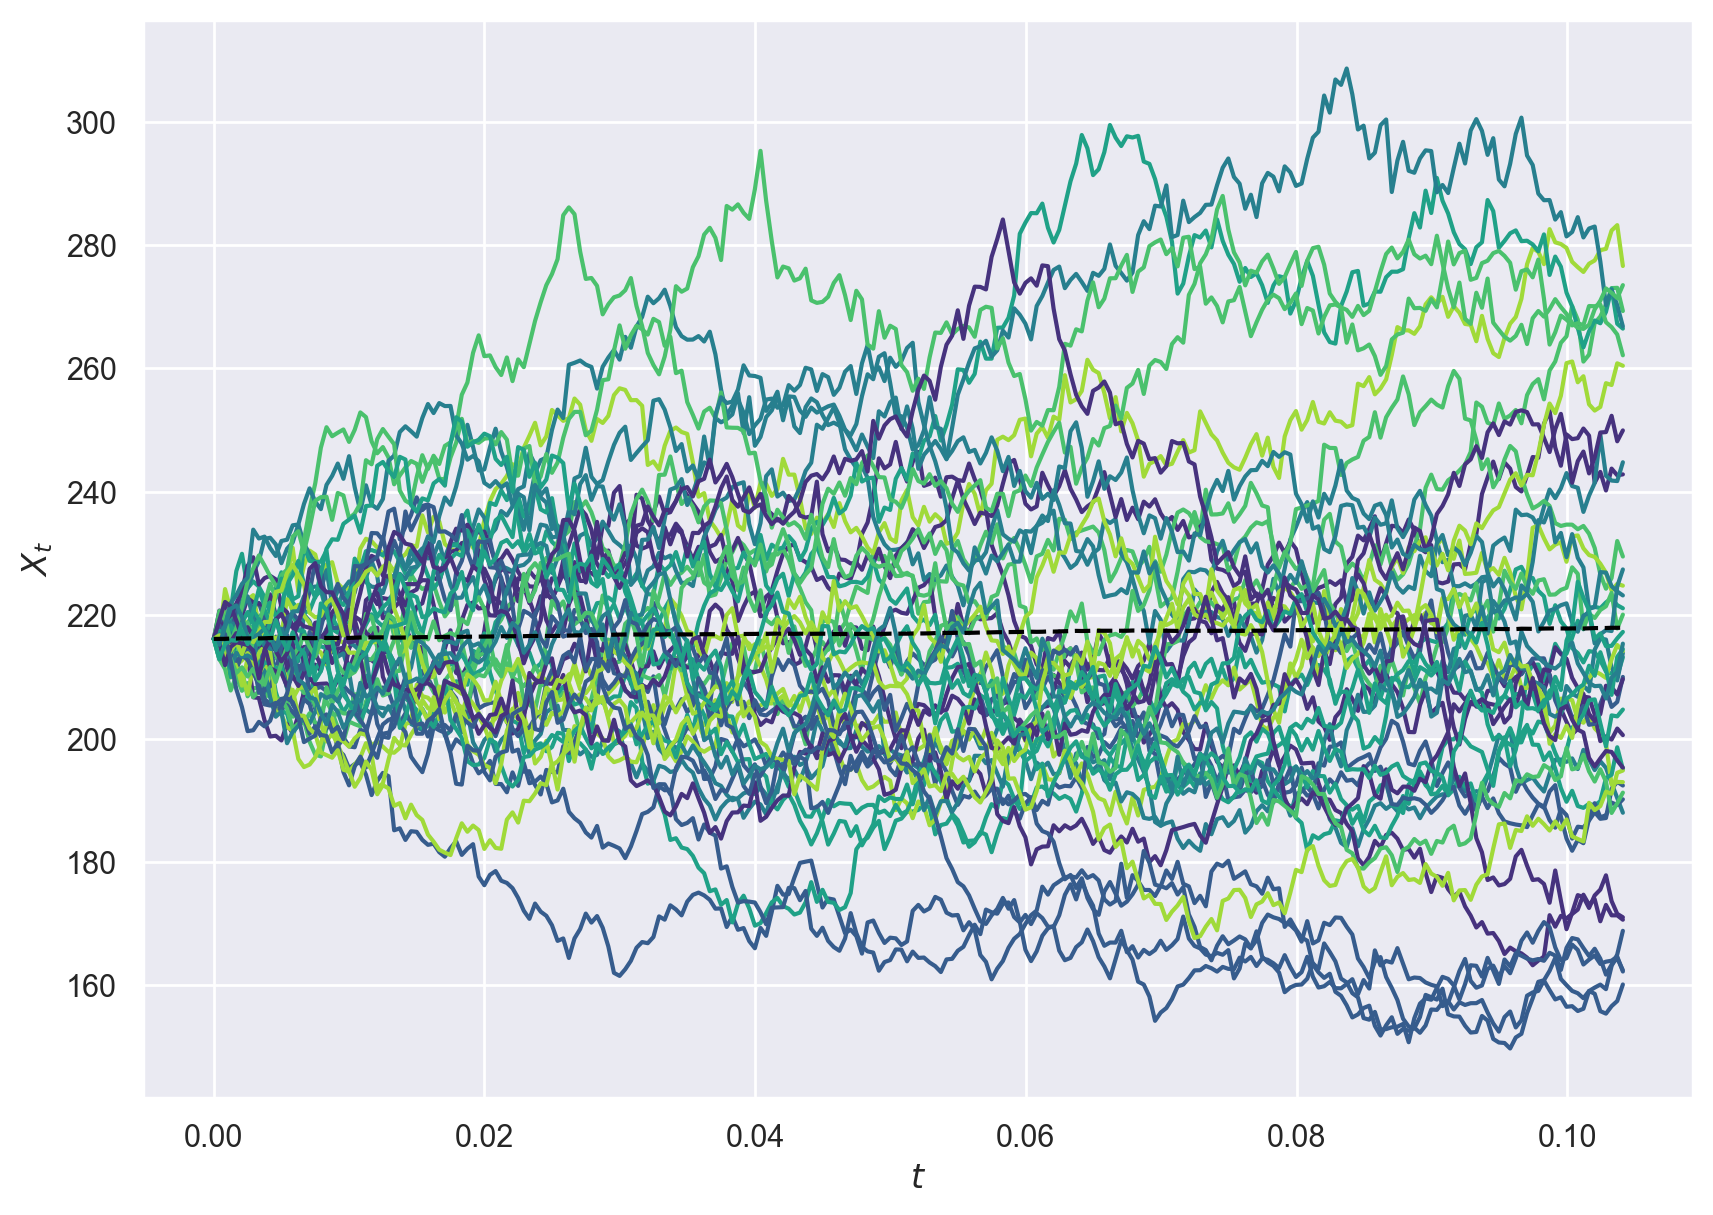

In [49]:
S = plotMonteCarlo(F0, r, sigma, T, save = False)

#### Стоимость базового актива в момент времени T подчиняется логнормальному закону

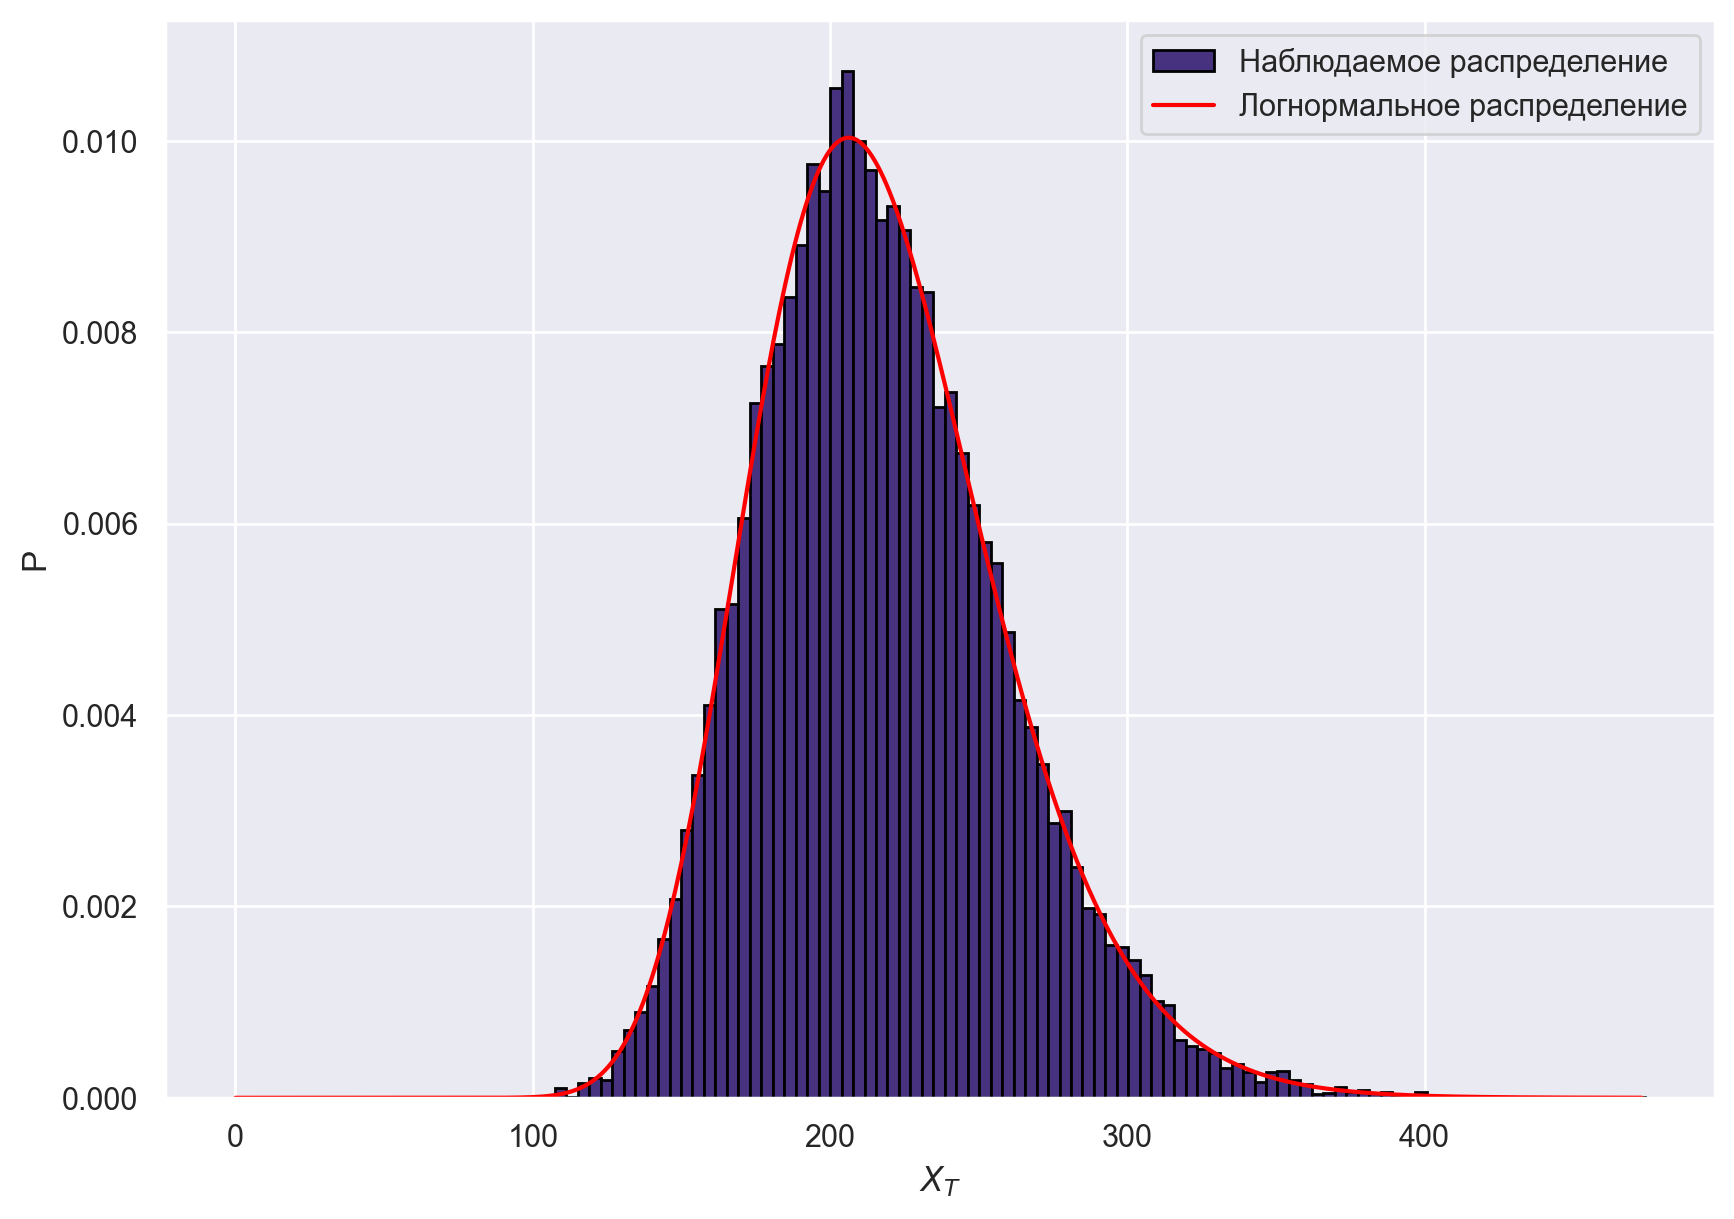

In [43]:
# Распределение цены базового актива
fig = plt.figure(figsize=(10, 7)) 
ax = fig.add_subplot(111)
ax.hist(S[:, -1], 100, density=True, ec='k', label='Наблюдаемое распределение')
ax.set_xlabel(r'$X_T$')
ax.set_ylabel('P')

# Fit a lognormal distribution
S_grid = range(int(S[:,-1].max())+1)
params = st.lognorm.fit(S[:,-1], scale=100)
pdf = st.lognorm.pdf(S_grid, *params)
ax.plot(S_grid, pdf, 'r', label='Логнормальное распределение')
ax.legend()
# plt.savefig('lognormal.png')

#### Примеры вычисления доходности опциона

In [44]:
warnings.filterwarnings('ignore')
abb={'c': 'Call',
    'p': 'Put',
    'b': 'Long',
    's': 'Short'}

def single_plotter(op_type = 'c',spot = 100, spot_range = 10,strike = 102,tr_type='b',op_pr=2, save=False, file='fig.png'):

    
    op_type=str.lower(op_type)
    tr_type=str.lower(tr_type)
    
    def payoff_calculator():
        x = spot * np.arange(100 - spot_range, 101 + spot_range, 0.01) / 100
        
        y = []
        if str.lower(op_type) == 'c':
            for i in range(len(x)):
                y.append(max((x[i] - strike - op_pr), -op_pr))
        else:
            for i in range(len(x)):
                y.append(max(strike - x[i] - op_pr, -op_pr))

        if str.lower(tr_type) == 's':
            y = -np.array(y)
        return x, y
        
    x,y = payoff_calculator()
    y0 = np.zeros_like(x)
    
    def plotter(x,y):
        plt.figure(figsize=(10,6), facecolor=(1, 1, 1))
        sns.lineplot(x=x, y=y)
        plt.axhline(color='k', linestyle='--')
        plt.axvline(x=spot, color='r', linestyle='--')
        plt.fill_between(x, y, 0, alpha=0.2, where=y>y0, facecolor='green', interpolate=True)
        plt.fill_between(x, y, 0, alpha=0.2, where=y<y0, facecolor='red', interpolate=True)
        plt.xlabel('Стоимость базового актива')
        plt.ylabel('Прибыль со сделки')
        plt.tight_layout()
        if save:
            plt.savefig(file)
        plt.show()
    
    plotter(x,y)

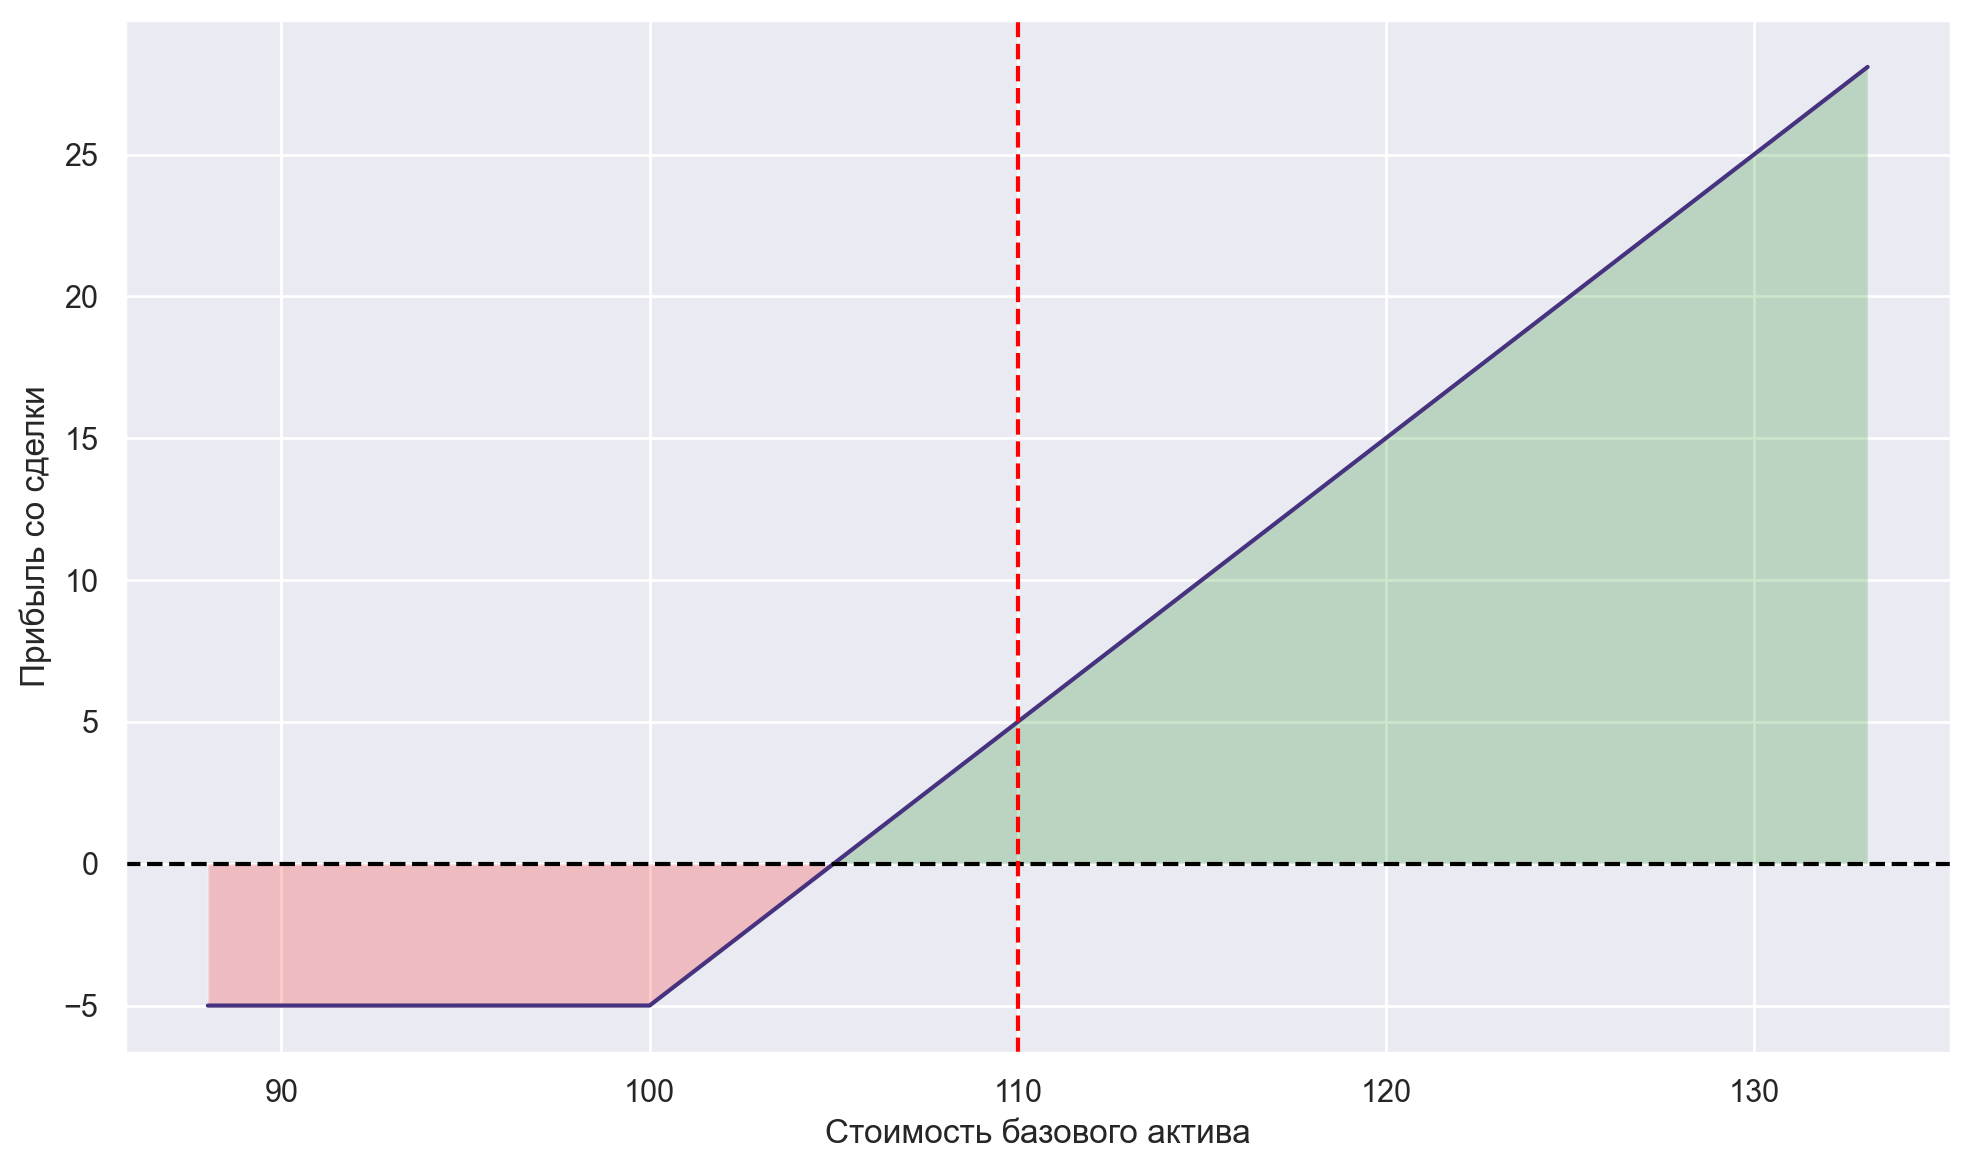

In [47]:
import matplotlib.pyplot as plt

single_plotter(spot=110, 
               spot_range = 20,
                  strike=100, 
                  op_type='c', 
                  tr_type='b', 
                  op_pr=5, 
                  save = False, 
#                   file = 'long_call_example.png'
              )

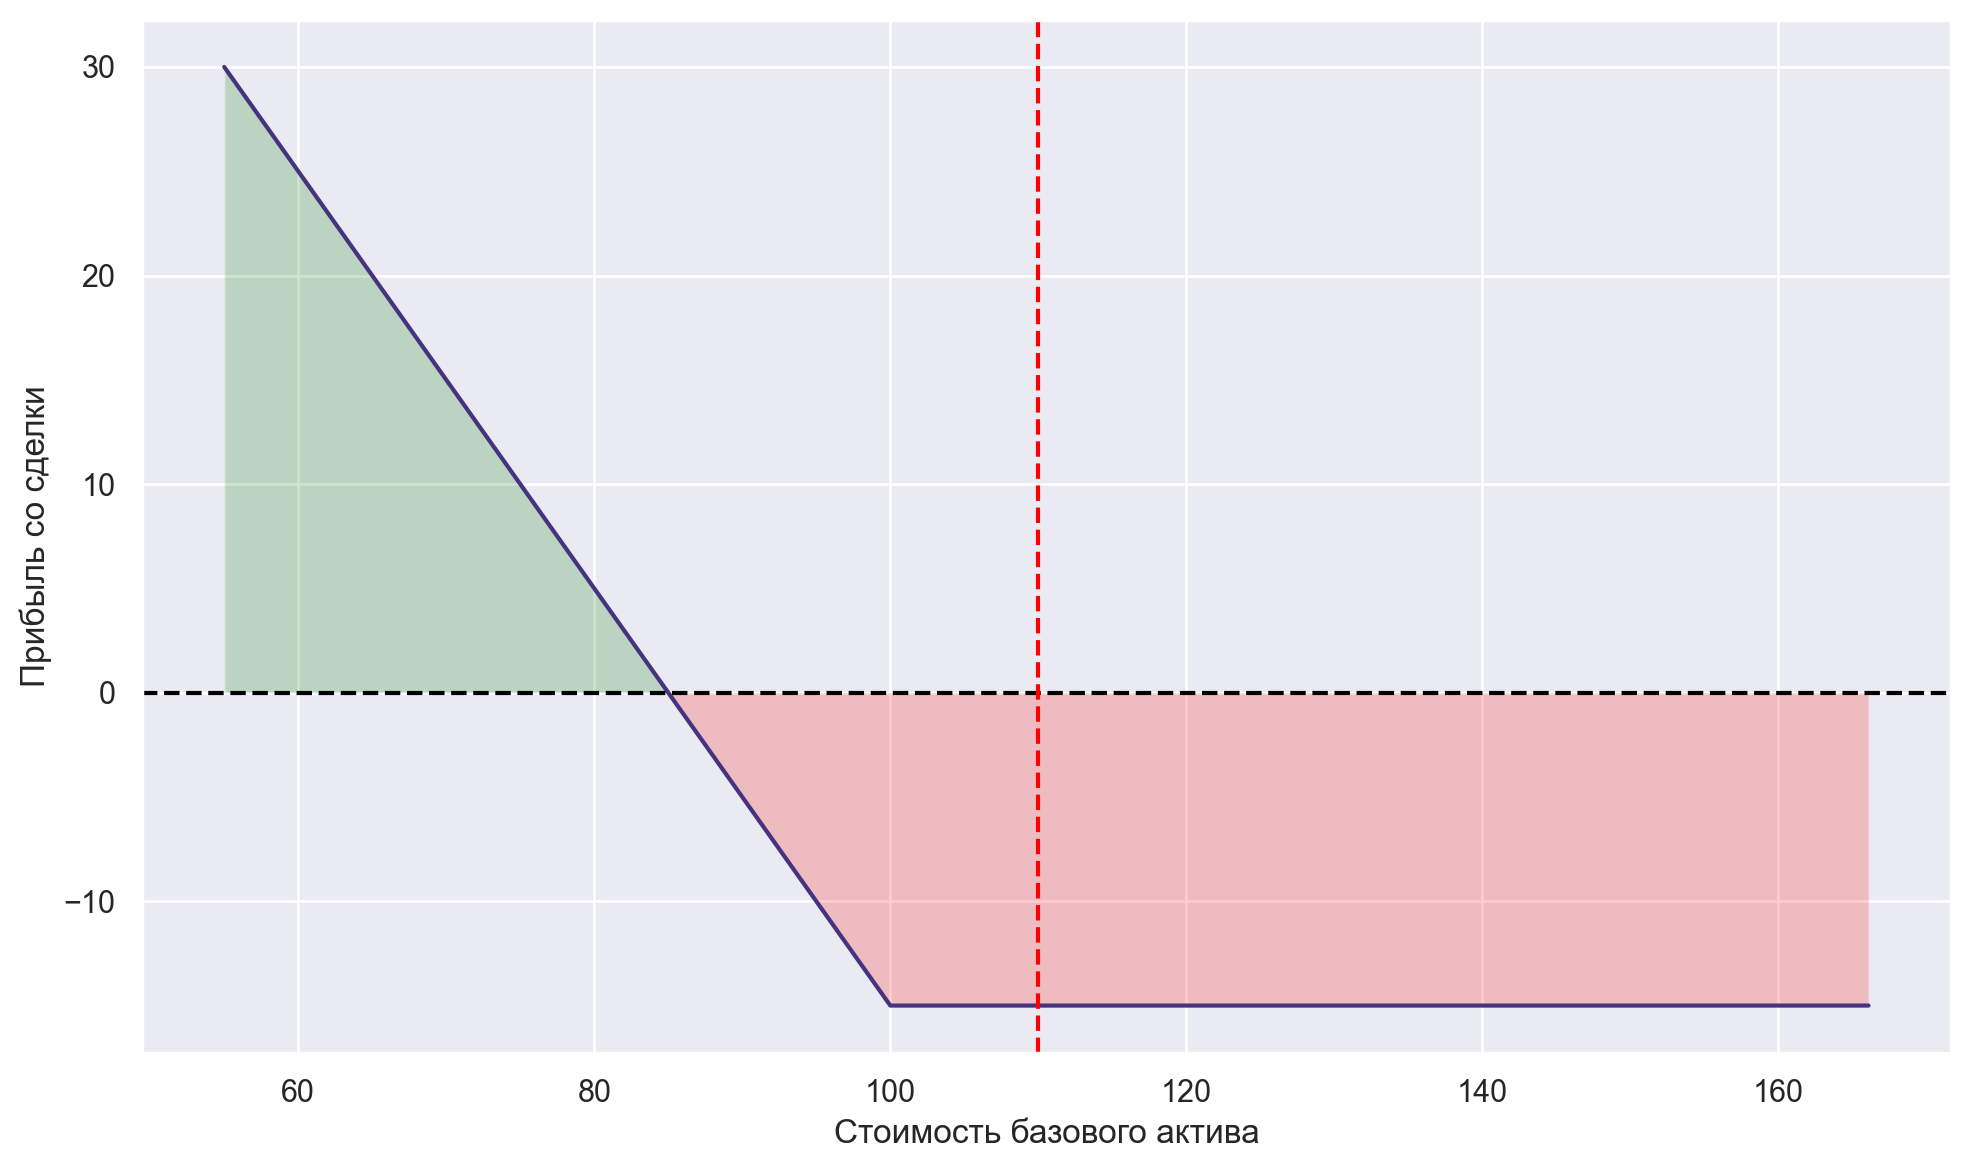

In [48]:
single_plotter(spot=110, 
               spot_range = 50,
                  strike=100, 
                  op_type='p', 
                  tr_type='b', 
                  op_pr=15,
                  save = False, 
#                   file = 'long_put_example.pdf'
              )